In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv("/content/drive/My Drive/data/DATA/lending_club_loan_two.csv")

In [0]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [0]:
df.dropna(inplace=True) # Dropping NaN values. Large enough sample to comfortably do this without losing too much data
df = pd.concat([pd.get_dummies(df["verification_status"]), df], axis=1) # Converting verification status from strings to numerical categories
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"])
df["earliest_cr_line"] = df["earliest_cr_line"].apply(lambda date:date.year) # Just need the year value
df["earliest_cr_line"].astype(int) # Converting value to integers rather than strings

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396024    1991
396025    2004
396026    2006
396027    1997
396028    1990
Name: earliest_cr_line, Length: 335868, dtype: int64

In [0]:
df["initial_list_status"] = df["initial_list_status"].map({"w":0, "f":1})
df["loan_status"] = df["loan_status"].map({"Fully Paid": 1, "Charged Off": 0})

In [0]:
num_convs = {"< 1 year": 0, "1 year": 1, "2 years": 2,
             "3 years": 3, "4 years": 4, "5 years": 5,
             "6 years": 6, "7 years": 7, "8 years": 8,
             "9 years": 9, "10+ years": 10}

df["emp_length"] = df["emp_length"].map(num_convs)

In [0]:
# Columns to be dropped
df.drop(["grade","sub_grade","title","term",
         "home_ownership","purpose","pub_rec",
         "application_type","mort_acc","pub_rec_bankruptcies",
         "address","emp_title","verification_status","issue_d"], axis=1, inplace=True)

In [0]:
df.head()

,Not Verified,Source Verified,Verified,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc,initial_list_status
0,1,0,0,10000.0,11.44,329.48,10,117000.0,1,26.24,1990,16.0,36369.0,41.8,25.0,0
1,1,0,0,8000.0,11.99,265.68,4,65000.0,1,22.05,2004,17.0,20131.0,53.3,27.0,1
2,0,1,0,15600.0,10.49,506.97,0,43057.0,1,12.79,2007,13.0,11987.0,92.2,26.0,1
3,1,0,0,7200.0,6.49,220.65,6,54000.0,1,2.60,2006,6.0,5472.0,21.5,13.0,1
4,0,0,1,24375.0,17.27,609.33,9,55000.0,0,33.95,1999,13.0,24584.0,69.8,43.0,1


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Defining target and features
X = df.drop("loan_status", axis=1).values
y = df["loan_status"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Scaling our data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Making sure dimensions are correct
print("X_train shape: {}".format(X_train.shape), "y_train shape: {}".format(y_train.shape), 
      "X_test shape: {}".format(X_test.shape), "y_test shape: {}".format(y_test.shape), sep="\n")

X_train shape: (268694, 15)
y_train shape: (268694,)
X_test shape: (67174, 15)
y_test shape: (67174,)


In [0]:
# Creating our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
num_dense_layers = 3
num_nodes = 16

model.add(Dense(15, activation="relu")) # Input layer (size 15 because input sizes are 1,15)

for layer in range(num_dense_layers):
  model.add(Dense(num_nodes, activation="relu"))

model.add(Dropout(0.5)) # Added to aid with overfitting
model.add(Dense(1, activation="sigmoid")) # Output layer. This is a binary classification problem so sigmoid (logistic) activation needed.

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

early_stop = EarlyStopping(patience=15, mode="min",restore_best_weights=True) # Added to avoid unnecessary training and potential overfitting

In [0]:
# Training the model
H = model.fit(X_train, y_train, batch_size=500, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stop])

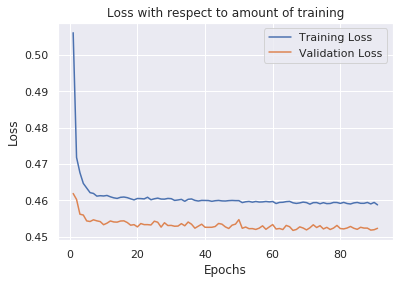

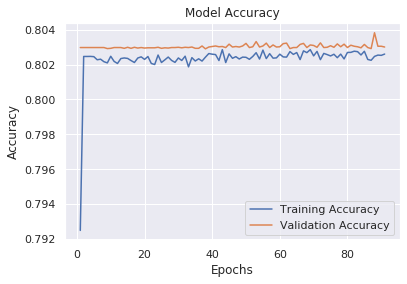

In [0]:
# Visualizing model performance
sns.set(style="darkgrid")

# Loss with respect to epochs
epochs = range(1, len(H.history["loss"])+1)
plt.plot(epochs, H.history["loss"], label="Training Loss")
plt.plot(epochs, H.history["val_loss"], label="Validation Loss")
plt.title("Loss with respect to amount of training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy with respect to epochs
plt.figure()
plt.plot(epochs, H.history["acc"], label="Training Accuracy")
plt.plot(epochs, H.history["val_acc"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [0]:
# Performance Metrics on training data
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_classes(X_train)
print(classification_report(y_train, predictions))
print(confusion_matrix(y_train, predictions))

              precision    recall  f1-score   support

           0       0.62      0.00      0.00     53077
           1       0.80      1.00      0.89    215617

    accuracy                           0.80    268694
   macro avg       0.71      0.50      0.45    268694
weighted avg       0.77      0.80      0.72    268694

[[    79  52998]
 [    49 215568]]


In [0]:
df["loan_status"].value_counts()

1    269556
0     66312
Name: loan_status, dtype: int64